# module import

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision
from torchvision.models import densenet161, densenet201
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
#import timm
import cv2

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
#!pip install wandb -qqq

In [ ]:
#import wandb

In [ ]:
#wandb.login()  #

In [ ]:
import platform
print(platform.platform())

# Determine if a GPU with CUDA support is available and use it; otherwise, use the CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
print(f"Using {device} device.\n")

Linux-5.15.120+-x86_64-with-glibc2.35
Using cuda device.



# 1. Data  (unzip train/test dataset)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EWHA/Term Project/dataset/231119_all/train.csv')
df.head()

,id,img_path,cat,name
0,TRAIN_0,./train/TRAIN_0.jpg,1,물냉면
1,TRAIN_1,./train/TRAIN_1.jpg,1,물냉면
2,TRAIN_2,./train/TRAIN_2.jpg,1,물냉면
3,TRAIN_3,./train/TRAIN_3.jpg,1,물냉면
4,TRAIN_4,./train/TRAIN_4.jpg,1,물냉면


In [ ]:
from sklearn.preprocessing import LabelEncoder

items = df['name']
encoder = LabelEncoder()
labels = encoder.fit_transform(items)
print(labels)

[28 28 28 ... 60 60 60]


In [ ]:
df['cat'] = labels # label = 0 ~ 15 -> 0 ~ 60 (소분류) 변경
df = df.iloc[:,1:3] # img_path, cat 열만 남기기

In [ ]:
df = df.rename(columns={'cat':'label'})
df

,img_path,label
0,./train/TRAIN_0.jpg,28
1,./train/TRAIN_1.jpg,28
2,./train/TRAIN_2.jpg,28
3,./train/TRAIN_3.jpg,28
4,./train/TRAIN_4.jpg,28
...,...,...
12155,./train/TRAIN_12155.jpg,60
12156,./train/TRAIN_12156.jpg,60
12157,./train/TRAIN_12157.jpg,60
12158,./train/TRAIN_12158.jpg,60


In [ ]:
df['label'].nunique()

64

In [ ]:
from collections import Counter
cnt = Counter(df['label'])
print(cnt)

Counter({28: 190, 26: 190, 25: 190, 45: 190, 24: 190, 49: 190, 40: 190, 48: 190, 46: 190, 30: 190, 11: 190, 53: 190, 27: 190, 10: 190, 7: 190, 58: 190, 18: 190, 9: 190, 3: 190, 51: 190, 21: 190, 5: 190, 23: 190, 42: 190, 56: 190, 54: 190, 43: 190, 36: 190, 35: 190, 12: 190, 2: 190, 47: 190, 62: 190, 8: 190, 22: 190, 59: 190, 57: 190, 31: 190, 50: 190, 1: 190, 20: 190, 13: 190, 55: 190, 61: 190, 34: 190, 19: 190, 52: 190, 63: 190, 15: 190, 4: 190, 6: 190, 32: 190, 41: 190, 14: 190, 29: 190, 33: 190, 44: 190, 16: 190, 17: 190, 38: 190, 39: 190, 37: 190, 0: 190, 60: 190})


In [ ]:
!mkdir data

In [ ]:
%cd /content/data

/content/data


In [ ]:
!mkdir train
!mkdir test

In [ ]:
%cd /content/data/train

/content/data/train


In [ ]:
!unzip "/content/drive/MyDrive/EWHA/Term Project/dataset/231119_all/train.zip"

In [ ]:
%cd /content/data/test

/content/data/test


In [ ]:
!unzip "/content/drive/MyDrive/EWHA/Term Project/dataset/231119_all/test.zip"

### png 확장자 붙이기

In [ ]:
import os

directory_path = '/content/data/train/content/train'
desired_extension = '.png'
files = os.listdir(directory_path)

for file in files:
    if not file.endswith(desired_extension):
        new_name = file + desired_extension

        # Build the full paths for the old and new names
        old_path = os.path.join(directory_path, file)
        new_path = os.path.join(directory_path, new_name)

        os.rename(old_path, new_path)

print("File extensions added to all training images.")

File extensions added to all training images.


In [ ]:
import os
directory_path = '/content/data/test/content/test'

desired_extension = '.png'

files = os.listdir(directory_path)

for file in files:
    if not file.endswith(desired_extension):
        new_name = file + desired_extension

        old_path = os.path.join(directory_path, file)
        new_path = os.path.join(directory_path, new_name)

        os.rename(old_path, new_path)

print("File extensions added to all test images.")

File extensions added to all test images.


In [ ]:
import os
from glob import glob

# 데이터 로딩용 함수 정의
def get_train_data(data_dir):
    """
    return:
      - img_path_list : 이미지 저장 폴더 경로 리스트
      - label_list : 레이블 리스트
    """
    img_path_list = []
    label_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('_')[-1].split('.')[0]))

    # get label
    label_list.extend(df['label'])

    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []

    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('_')[-1].split('.')[0]))

    return img_path_list

## Check Data

In [ ]:
all_img_path, all_label = get_train_data('/content/data/train/content/train')

In [ ]:
test_img_path = get_test_data('/content/data/test/content/test')

In [ ]:
all_label[-10:-5]

[60, 60, 60, 60, 60]

In [ ]:
all_img_path[-10:-5]

['/content/data/train/content/train/TRAIN_12150.png',
 '/content/data/train/content/train/TRAIN_12151.png',
 '/content/data/train/content/train/TRAIN_12152.png',
 '/content/data/train/content/train/TRAIN_12153.png',
 '/content/data/train/content/train/TRAIN_12154.png']

In [ ]:
test_img_path[:5]

['/content/data/test/content/test/TEST_0.png',
 '/content/data/test/content/test/TEST_1.png',
 '/content/data/test/content/test/TEST_2.png',
 '/content/data/test/content/test/TEST_3.png',
 '/content/data/test/content/test/TEST_4.png']

In [ ]:
from collections import Counter
cnt = Counter(all_label)
print(cnt)

Counter({28: 190, 26: 190, 25: 190, 45: 190, 24: 190, 49: 190, 40: 190, 48: 190, 46: 190, 30: 190, 11: 190, 53: 190, 27: 190, 10: 190, 7: 190, 58: 190, 18: 190, 9: 190, 3: 190, 51: 190, 21: 190, 5: 190, 23: 190, 42: 190, 56: 190, 54: 190, 43: 190, 36: 190, 35: 190, 12: 190, 2: 190, 47: 190, 62: 190, 8: 190, 22: 190, 59: 190, 57: 190, 31: 190, 50: 190, 1: 190, 20: 190, 13: 190, 55: 190, 61: 190, 34: 190, 19: 190, 52: 190, 63: 190, 15: 190, 4: 190, 6: 190, 32: 190, 41: 190, 14: 190, 29: 190, 33: 190, 44: 190, 16: 190, 17: 190, 38: 190, 39: 190, 37: 190, 0: 190, 60: 190})


In [ ]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# 2. Settings (Hyperparameters)

In [ ]:
####################### edit here ############################


# CFG = {
#     'IMG_SIZE':224, ###
#     'MODEL_NAME':'densenet161',
#     'EPOCHS':20, #25,10,15
#     'LEARNING_RATE':1e-4, #2e-4,1e-7, 1e-5
#     'BATCH_SIZE':16, #12,8
#     'SEED':42,
#     'CLASSES':15, #3
#     'THRESHOLD':80.0
# }


# https://docs.wandb.ai/guides/sweeps/define-sweep-configuration#early_terminate

sweep_config = {
    "method": "random",
    "model_name": 'densenet161',
    "name": "loss",
    "metric": {"goal": "minimize", "name": "validation_loss"},
    "parameters": {
        "epochs": {"values": [10, 15]},
        },
    "early_terminate": {
        "type": "hyperband",
        "eta": 2,
        "min_iter":2
     }
}

###############################################################

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'early_terminate': {'eta': 2, 'min_iter': 2, 'type': 'hyperband'},
 'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'validation_loss'},
 'model_name': 'densenet161',
 'name': 'loss',
 'parameters': {'batch_size': {'values': 5},
                'epochs': {'values': [10, 15]},
                'lr': {'values': 5e-05}}}


# 3. Data Preprocessing

## 1) Custom dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) ### RGB로 재변환

        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image

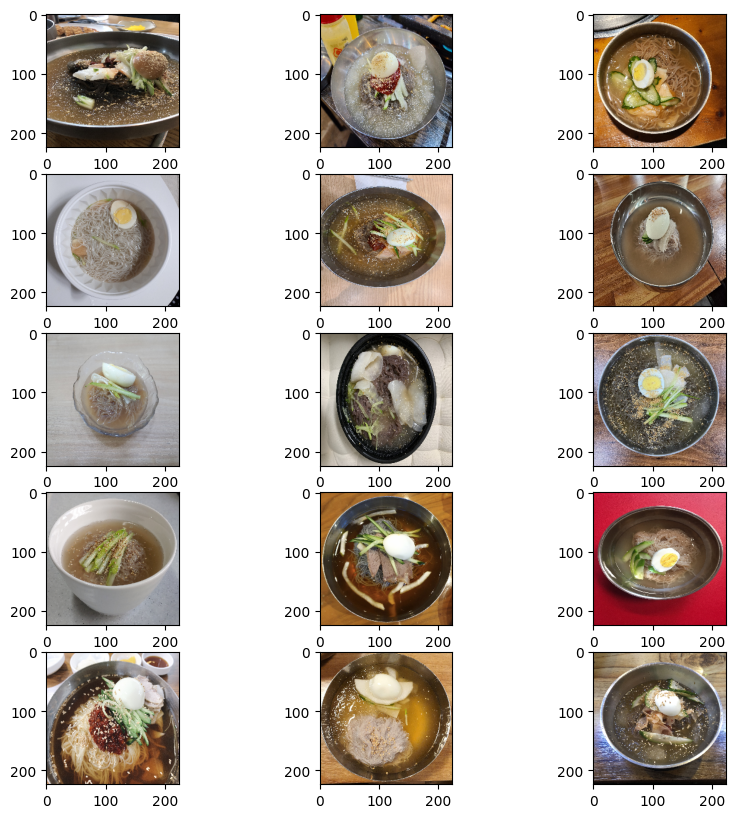

In [ ]:
back_list = []
back_path = all_img_path[:50]
for i in back_path:
    back_image = cv2.imread(i)
    back_image = cv2.cvtColor(back_image, cv2.COLOR_BGR2RGB)
    back_image = cv2.resize(back_image, (224,224))
    back_list.append(back_image)

fig = plt.figure(figsize=(10,10))
for i, img in enumerate(back_list[:15]):
    plt.subplot(5, 3, i+1)
    plt.imshow(img)
#plt.tight_layout()
#plt.show()

## 2) Split train / valid set
- shuffle dataset (to make ununiform)

In [ ]:
all_labels = df['label']
n_class = 64

# Dictionary
class_indices = {i: [j for j, label in enumerate(all_labels) if label == i] for i in range(n_class)} ## # of class = 15

# Shuffle
for i in range(15):
    random.shuffle(class_indices[i])

split_ratio = 0.75 #####
split_indices = {i: int(len(class_indices[i]) * split_ratio) for i in range(n_class)}

train_indices = [class_indices[i][:split_indices[i]] for i in range(n_class)]
vali_indices = [class_indices[i][split_indices[i]:] for i in range(n_class)]
train_indices = [item for sublist in train_indices for item in sublist]
vali_indices = [item for sublist in vali_indices for item in sublist]

random.shuffle(train_indices)
random.shuffle(vali_indices)

train_img_path = [all_img_path[i] for i in train_indices]
train_label = [all_label[i] for i in train_indices]

vali_img_path = [all_img_path[i] for i in vali_indices]
vali_label = [all_label[i] for i in vali_indices]




train_len = len(train_img_path)
vali_len = len(vali_img_path)

print("Train set 길이:", train_len)
print("Validation set 길이:", vali_len)

Train set 길이: 9088
Validation set 길이: 3072


## 3) Transform

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape `(3 x H x W)`, where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`
- ref : https://pytorch.org/hub/pytorch_vision_densenet/

https://jungnamgyu.tistory.com/32

https://incredible.ai/pytorch/2020/04/25/Pytorch-Image-Augmentation/

In [ ]:
mean = (0.485, 0.456, 0.406)
std =  (0.229, 0.224, 0.225)

In [ ]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, fill=0),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

## 4) DataLoader

In [ ]:
#train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transform)
#train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

#vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=transform)
#vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
#train_batches = len(train_loader)
#vali_batches = len(vali_loader)
# 1708 / 12 = 142.3x
# 571 / 12  = 47.58x
#print("total train imgs :",train_len,'/total train batches :',train_batches)
#print("total valid imgs :",vali_len,'/total valid batches :',vali_batches)

# 4. Modeling

https://pytorch.org/vision/0.8/models.html

**summary**
- model : densenet161
- optimizer : adam
- loss func : crossentropyloss
- lr scheduler : steplr

In [ ]:
# # # # classifier
# model = torchvision.models.densenet161(weights='DEFAULT').to(device) #### densenet161, densenet201 #### edit here #####

# model.classifier

In [ ]:
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params = model.parameters(),  lr=sweep_config['learning_rate']) # Default lr = 0.001
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5)

In [ ]:
def float_2_string(float_value):
    """
    ex.
    float_value = 87.987 -> string '87_99'
    """
    float_str = str(round(float_value, 2)).replace('.', '_')
    return float_str


def train(model, optimizer, criterion, train_loader, vali_loader, scheduler, device, w_config, wandb):
    model.to(device)

    wandb.watch(model, criterion, log="all", log_freq = 10)

    n = len(train_loader)
    best_acc = 0

    for epoch in range(1, w_config.epochs + 1):
        model.train() #모델 학습
        running_loss = 0.0
        train_correct = 0

        for img, label in tqdm(iter(train_loader)):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad() #배치마다 optimizer 초기화

            logit = model(img) # 예측값 산출
            loss = criterion(logit, label)
            pred = logit.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(label.view_as(pred)).sum().item()

            # Backpropagation
            loss.backward()
            optimizer.step() #가중치 최적화
            running_loss += loss.item()

        print("EPOCH [%d] Train loss: %.10f | Train Accuracy *.10f "%(epoch, running_loss / len(train_loader) ), 100 * train_correct / len(train_loader.dataset))
        #wandb.log({"train_loss": running_loss / len(train_loader), "train_acc" : 100 * train_correct / len(train_loader.dataset) }, step = epoch)

        if scheduler is not None:
            scheduler.step()

        #Validation set evaluation
        model.eval()

        vali_loss = 0.0
        correct = 0
        with torch.no_grad():
            for img, label in tqdm(iter(vali_loader)):
                img, label = img.to(device), label.to(device)

                logit = model(img)
                vali_loss += criterion(logit, label)
                pred = logit.argmax(dim=1, keepdim=True) # 15개의 class중 가장 값이 높은 것을 예측 label로 추출
                correct += pred.eq(label.view_as(pred)).sum().item()

        vali_acc = 100 * correct / len(vali_loader.dataset)
        avg_loss = vali_loss / len(vali_loader)


        print('Vali set: Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(vali_loss / len(vali_loader), correct, len(vali_loader.dataset), 100 * correct / len(vali_loader.dataset)))

        wandb.log({"val_loss": avg_loss, "val_acc" : vali_acc,
                   "train_loss": running_loss / len(train_loader), "train_acc" : 100 * train_correct / len(train_loader.dataset)}, step = epoch)

        model_name = 'e' + str(epoch) + '_' + float_2_string(vali_acc) + '_model.pth'

        if best_acc < vali_acc:
            best_acc = vali_acc
            dir = '/content/drive/MyDrive/EWHA/Machine_Learning/' + model_name
            torch.save(model.state_dict(), dir)  #
            print('################ Best Model Saved.##############\n')

In [ ]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
def run(config=None):
   # project에 project 이름,
    # entity에는 wandb의 id

    wandb.init(project='TermProject', entity='finallyupper', config=config)
    w_config = wandb.config

    train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transform)
    train_loader = DataLoader(train_dataset, batch_size = 5, shuffle=True, num_workers=0)

    vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=transform)
    vali_loader = DataLoader(vali_dataset, batch_size = 5, shuffle=False, num_workers=0)

    model = torchvision.models.densenet161(weights='DEFAULT').to(device) #### densenet161, densenet201 #### edit here #####

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params = model.parameters(),  lr = 0.00005) # Default lr = 0.001
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    train(model, optimizer, criterion, train_loader, vali_loader, scheduler, device, w_config, wandb)

    return model

In [ ]:
sweep_id = wandb.sweep(sweep_config, project = "TermProject", entity = 'finallyupper')

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('model_name' was unexpected)


Create sweep with ID: r6t9lefa
Sweep URL: https://wandb.ai/finallyupper/TermProject/sweeps/r6t9lefa


In [ ]:
wandb.agent(sweep_id, run, count = 6)

wandb: Agent Starting Run: x2q24wx4 with config:
wandb: 	epochs: 10
wandb: Currently logged in as: finallyupper. Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 180MB/s]
100%|██████████| 1818/1818 [36:29<00:00,  1.20s/it]


EPOCH [1] Train loss: 2.3733351466 | Train Accuracy *.10f  43.485915492957744


100%|██████████| 615/615 [11:34<00:00,  1.13s/it]


Vali set: Loss: 1.0254, Accuracy: 2224/3072 (72%)

################ Best Model Saved.##############



100%|██████████| 1818/1818 [37:07<00:00,  1.23s/it]


EPOCH [2] Train loss: 1.1483290336 | Train Accuracy *.10f  68.61795774647888


100%|██████████| 615/615 [11:18<00:00,  1.10s/it]


Vali set: Loss: 0.8350, Accuracy: 2405/3072 (78%)

################ Best Model Saved.##############



100%|██████████| 1818/1818 [36:24<00:00,  1.20s/it]


EPOCH [3] Train loss: 0.8668906547 | Train Accuracy *.10f  75.37411971830986


100%|██████████| 615/615 [11:32<00:00,  1.13s/it]


Vali set: Loss: 0.6120, Accuracy: 2533/3072 (82%)

################ Best Model Saved.##############



100%|██████████| 1818/1818 [37:15<00:00,  1.23s/it]


EPOCH [4] Train loss: 0.7162459272 | Train Accuracy *.10f  79.95158450704226


100%|██████████| 615/615 [11:22<00:00,  1.11s/it]


Vali set: Loss: 0.6282, Accuracy: 2558/3072 (83%)

################ Best Model Saved.##############



100%|██████████| 1818/1818 [37:27<00:00,  1.24s/it]


EPOCH [5] Train loss: 0.6174932797 | Train Accuracy *.10f  82.29533450704226


100%|██████████| 615/615 [11:34<00:00,  1.13s/it]


Vali set: Loss: 0.5198, Accuracy: 2610/3072 (85%)

################ Best Model Saved.##############



100%|██████████| 1818/1818 [37:56<00:00,  1.25s/it]


EPOCH [6] Train loss: 0.5427766252 | Train Accuracy *.10f  84.45202464788733


100%|██████████| 615/615 [11:48<00:00,  1.15s/it]


Vali set: Loss: 0.5777, Accuracy: 2588/3072 (84%)



100%|██████████| 1818/1818 [37:59<00:00,  1.25s/it]


EPOCH [7] Train loss: 0.4801824871 | Train Accuracy *.10f  86.20158450704226


100%|██████████| 615/615 [11:44<00:00,  1.15s/it]


Vali set: Loss: 0.5215, Accuracy: 2667/3072 (87%)

################ Best Model Saved.##############



100%|██████████| 1818/1818 [37:54<00:00,  1.25s/it]


EPOCH [8] Train loss: 0.3200940804 | Train Accuracy *.10f  91.23019366197182


100%|██████████| 615/615 [11:38<00:00,  1.14s/it]


Vali set: Loss: 0.3907, Accuracy: 2745/3072 (89%)

################ Best Model Saved.##############



100%|██████████| 1818/1818 [37:57<00:00,  1.25s/it]


EPOCH [9] Train loss: 0.2631508538 | Train Accuracy *.10f  92.8587147887324


100%|██████████| 615/615 [11:48<00:00,  1.15s/it]


Vali set: Loss: 0.3650, Accuracy: 2765/3072 (90%)

################ Best Model Saved.##############



100%|██████████| 1818/1818 [38:06<00:00,  1.26s/it]


EPOCH [10] Train loss: 0.2336673356 | Train Accuracy *.10f  93.78301056338029


100%|██████████| 615/615 [11:49<00:00,  1.15s/it]


Vali set: Loss: 0.3566, Accuracy: 2749/3072 (89%)



train_acc,▁▄▅▆▆▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▃▅▅▆▆▇███
val_loss,█▆▄▄▃▃▃▁▁▁
train_acc,93.78301
train_loss,0.23367
val_acc,89.48568
val_loss,0.35657


wandb: Agent Starting Run: 7lopwvm4 with config:
wandb: 	epochs: 15
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


 32%|███▏      | 587/1818 [11:41<26:20,  1.28s/it]

# 5. Train

In [ ]:
#train(model, optimizer, train_loader, scheduler, device)

# 6. Prediction (on raw dataset)

In [ ]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
def accuracy(pred, ans):
  """
  둘다 리스트
  """
  cnt = 0
  for i in range(len(pred)):
    if(pred[i] == ans[i]):
      cnt += 1
  return cnt / len(pred) * 100

In [ ]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size = 5, shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/drive/MyDrive/EWHA/Machine_Learning/e9_90_01_model.pth')
model = torchvision.models.densenet161(weights='DEFAULT').to(device) #### edit here #####
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)

100%|██████████| 128/128 [02:18<00:00,  1.08s/it]


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/EWHA/Term Project/dataset/231119_all/test.csv')
test_df = test_df.rename(columns={'cat':'label'})
test_df.head()

,id,img_path,label,name
0,TEST_0,./train/TEST_0.jpg,1,물냉면
1,TEST_1,./train/TEST_1.jpg,1,물냉면
2,TEST_2,./train/TEST_2.jpg,1,물냉면
3,TEST_3,./train/TEST_3.jpg,1,물냉면
4,TEST_4,./train/TEST_4.jpg,1,물냉면


In [ ]:
items = test_df['name']
encoder = LabelEncoder()
labels = encoder.fit_transform(items)
test_df['label'] = labels ##
test_df.head()

,id,img_path,label,name
0,TEST_0,./train/TEST_0.jpg,28,물냉면
1,TEST_1,./train/TEST_1.jpg,28,물냉면
2,TEST_2,./train/TEST_2.jpg,28,물냉면
3,TEST_3,./train/TEST_3.jpg,28,물냉면
4,TEST_4,./train/TEST_4.jpg,28,물냉면


In [ ]:
test_df = test_df.iloc[:, 1:3]
test_df['label'].nunique()

64

In [ ]:
labels = [i for i in range(64)]
answers = test_df['label']

In [ ]:
from sklearn.metrics import f1_score

mic = f1_score(answers, preds, average='micro', labels = labels)
mac = f1_score(answers, preds, average='macro', labels = labels)
weighted = f1_score(answers, preds, average='weighted', labels = labels)
#[‘micro’, ‘macro’, ‘samples’,’weighted’ 중 하나 선택])

In [ ]:
print('Accuracy = ', accuracy(preds, answers))
print('mic =', mic)
print('mac =', mac)
print('weighted =', weighted)

Accuracy =  90.0
mic = 0.9
mac = 0.8987885928893089
weighted = 0.8987885928893089


In [ ]:
pred_df = pd.DataFrame({'img_path':test_img_path, 'pred_label': preds, 'label' : answers })
pred_df.to_csv('/content/drive/MyDrive/EWHA/Machine_Learning/231202_densenet161_pred.csv')